## Задача
### Data Description
The aim of this competition is to predict the sale price of each property. The target variable is called price_doc in train.csv.

The training data is from August 2011 to June 2015, and the test set is from July 2015 to May 2016. The dataset also includes information about overall conditions in Russia's economy and finance sector, so you can focus on generating accurate price forecasts for individual properties, without needing to second-guess what the business cycle will do.

### Data Files

train.csv, test.csv: information about individual transactions. The rows are indexed by the "id" field, which refers to individual transactions (particular properties might appear more than once, in separate transactions). These files also include supplementary information about the local area of each property.
macro.csv: data on Russia's macroeconomy and financial sector (could be joined to the train and test sets on the "timestamp" column)
sample_submission.csv: an example submission file in the correct format
data_dictionary.txt: explanations of the fields available in the other data files
Update: please see the pinned discussion thread for some optional extra data, resolving an issue with some GIS features.

### Solution Path
Download data from
https://www.kaggle.com/c/sberbank-russian-housing-market/data

- Do some EDA
- Train XGBoost
- Try 'hyperopt' library for parameters optimization (at least 5 parameters should be optimized)
- Provide importance of features
- Play with early_stopping
- Set couple of evaluation metrics. They should be printer for each iteration during training
- BONUS: beat baseline
- BONUS: train ADABoost for comparison
- BONUS: use some external data

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

### Запуск xgboost на пвевдо-очищенные данных

In [2]:
train = pd.read_csv("data/train.csv", index_col="id", parse_dates=["timestamp"])
test = pd.read_csv("data/test.csv", index_col="id", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

In [3]:
train.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
test.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
id,,,,,,,,,,,,,,,,,,,,,
30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,...,8,0,0,0,1,10,1,0,14,1
30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,1.0,...,4,1,1,0,2,11,0,1,12,1
30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,...,42,11,4,0,10,21,0,10,71,11
30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,...,1,1,2,0,0,10,0,0,2,0
30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,1.0,...,5,1,1,0,2,12,0,1,11,1


In [5]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [8]:
y_train = train["price_doc"]
x_train = train.drop(["timestamp", "price_doc"], axis=1)

Поменяем не численные типы данных

In [9]:
for i in x_train.columns:
    if x_train[i].dtype == "object":
        label = preprocessing.LabelEncoder()
        label.fit(list(x_train[i].values)) 
        x_train[i] = label.transform(list(x_train[i].values))

In [10]:
x_test = test.drop(["timestamp"], axis=1)

In [11]:
for i in x_test.columns:
    if x_test[i].dtype == "object":
        label = preprocessing.LabelEncoder()
        label.fit(list(x_test[i].values)) 
        x_test[i] = label.transform(list(x_test[i].values))

#### Подберем параметры для оптимизации xgboost
При помощи $Hyperopt$

https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model

In [31]:
# Hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
# Some constants

SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

#-------------------------------------------------#

# Utility functions

def intersect(l_1, l_2):
    return list(set(l_1) & set(l_2))


def get_features(train, test):
    intersecting_features = intersect(train.columns, test.columns)
    return sorted(intersecting_features)

#-------------------------------------------------#

# Scoring and optimization functions


def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(train_features, label=y_train)
    dvalid = xgb.DMatrix(valid_features, label=y_valid)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_valid, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=250)
    return best

In [33]:
train_df = pd.read_csv('data/train.csv').head(100)
test_df = pd.read_csv('data/test.csv').head(100)

FEATURES = get_features(train_df, test_df)
print(FEATURES)

['0_13_all', '0_13_female', '0_13_male', '0_17_all', '0_17_female', '0_17_male', '0_6_all', '0_6_female', '0_6_male', '16_29_all', '16_29_female', '16_29_male', '7_14_all', '7_14_female', '7_14_male', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', 'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk', 'ID_railroad_terminal', 'additional_education_km', 'additional_education_raion', 'area_m', 'basketball_km', 'big_church_count_1000', 'big_church_count_1500', 'big_church_count_2000', 'big_church_count_3000', 'big_church_count_500', 'big_church_count_5000', 'big_church_km', 'big_market_km', 'big_market_raion', 'big_road1_1line', 'big_road1_km', 'big_road2_km', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'build_count_before_1920', 'build_count_block', 'build_count_brick', 'build_count_foam', 'build_count_frame', 'build_count_mix', 'build_count_monolith', 'build_count_panel', 'build_count_slag', 'build_count_wood', 'bu

In [34]:
train, valid = train_test_split(train_df, test_size=VALID_SIZE,
                                random_state=SEED)
train_features = train[FEATURES]
valid_features = valid[FEATURES]
y_train = train[TARGET]
y_valid = valid[TARGET]

print('The training set is of length: ', len(train.index))
print('The validation set is of length: ', len(valid.index))

KeyError: 'outcome'

## Короче я не понял, как это делать. Так что подберем руками :D

In [12]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "seed":42
}

In [13]:
dtrain = xgb.DMatrix(x_train, y_train)

In [14]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.20552e+06	test-rmse:8.21233e+06
[50]	train-rmse:2.53422e+06	test-rmse:2.90077e+06
[100]	train-rmse:2.19598e+06	test-rmse:2.71451e+06
[150]	train-rmse:2.07905e+06	test-rmse:2.67354e+06
[200]	train-rmse:1.9912e+06	test-rmse:2.65576e+06
[250]	train-rmse:1.92183e+06	test-rmse:2.64652e+06
[300]	train-rmse:1.85985e+06	test-rmse:2.64064e+06
[350]	train-rmse:1.80693e+06	test-rmse:2.63987e+06


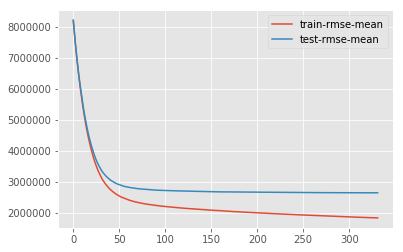

In [15]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()

In [16]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

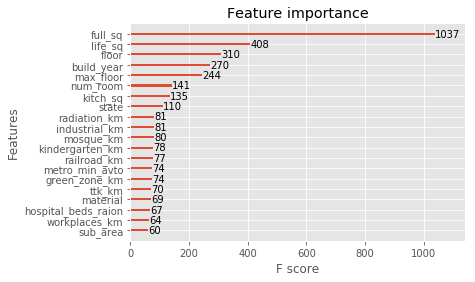

In [18]:
xgb.plot_importance(model, max_num_features=20)

Построим модель предикта

In [19]:
pred = model.predict(dtrain)

Возьмем среднюю ошибку

In [20]:
error = np.mean(abs(pred - y_train)) / len(y_train)

Посчитаем ошибку RMSLE

In [21]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [22]:
print("RMSLE: {}, Error: {}".format(rmsle, error))

RMSLE: nan, Error: 39.29211739451779


In [23]:
dtest = xgb.DMatrix(x_test)

In [24]:
y_predict = model.predict(dtest)

In [25]:
output = pd.DataFrame({'id': x_test.index, 'price_doc' : y_predict})

In [26]:
output.to_csv('submissions.csv', index = False)

In [27]:
sub = pd.read_csv('submissions.csv')
sub.head()

,id,price_doc
0,30474,5411186.0
1,30475,8362256.5
2,30476,5614534.5
3,30477,6082197.0
4,30478,5146532.5


## Обучаем xgboost на чищенных данных

#### Загружаем данные

In [28]:
train = pd.read_csv("data/train_clean.csv", index_col="id", parse_dates=["timestamp"])
test = pd.read_csv("data/test_clean.csv", index_col="id", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

#### Заменяем не числовые данные

In [29]:
y_train = train["price_doc"]
x_train = train.drop(["timestamp", "price_doc"], axis=1)

for i in x_train.columns:
    if x_train[i].dtype == "object":
        label = preprocessing.LabelEncoder()
        label.fit(list(x_train[i].values)) 
        x_train[i] = label.transform(list(x_train[i].values))

y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

In [30]:
x_test = test.drop(["timestamp"], axis=1)

for i in x_test.columns:
    if x_test[i].dtype == "object":
        label = preprocessing.LabelEncoder()
        label.fit(list(x_test[i].values)) 
        x_test[i] = label.transform(list(x_test[i].values))
        
x_test = x_test.astype(np.float32)

#### Подборка параметров при помощи руки
или можно использовать https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model

In [31]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "seed":42
}

In [32]:
dtrain = xgb.DMatrix(x_train, y_train)

In [33]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.1042e+06	test-rmse:8.10894e+06
[50]	train-rmse:2.46663e+06	test-rmse:2.80001e+06
[100]	train-rmse:2.16144e+06	test-rmse:2.63631e+06
[150]	train-rmse:2.04964e+06	test-rmse:2.60458e+06
[200]	train-rmse:1.965e+06	test-rmse:2.59003e+06
[250]	train-rmse:1.89562e+06	test-rmse:2.58069e+06
[300]	train-rmse:1.83547e+06	test-rmse:2.57674e+06
[350]	train-rmse:1.78158e+06	test-rmse:2.57538e+06


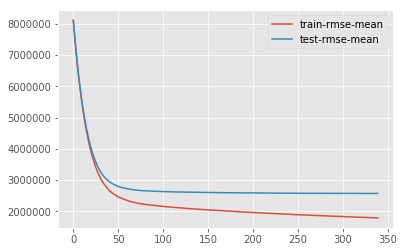

In [34]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()

In [35]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

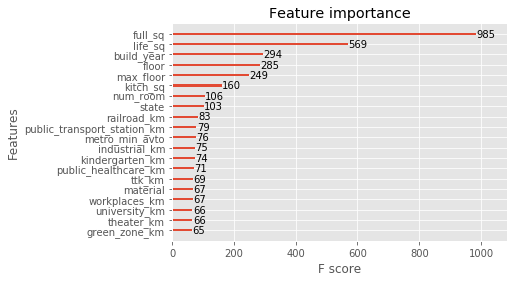

In [36]:
xgb.plot_importance(model, max_num_features=20)

In [37]:
pred = model.predict(dtrain)

In [38]:
error = np.mean(abs(pred - y_train)) / len(y_train)

In [39]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

In [40]:
print("RMSLE: {}, Error: {}".format(rmsle, error))

RMSLE: 12930.383284960895, Error: 41.79482206838974


In [41]:
dtest = xgb.DMatrix(x_test)

In [42]:
y_predict = model.predict(dtest)

In [43]:
output = pd.DataFrame({'id': x_test.index, 'price_doc' : y_predict})

In [44]:
output.to_csv('submissions.csv', index = False)

In [45]:
sub = pd.read_csv('submissions.csv')
sub.head()

,id,price_doc
0,30474,5633907.5
1,30475,8262775.5
2,30476,5417580.0
3,30477,5979684.5
4,30478,5207153.0
